## **TKAN**

In [1]:
%pip install yfinance scikit-learn tensorflow tkan torch matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tkan import TKAN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score


ticker = '^GSPC'

sp500_data = yf.download(ticker, start='2015-01-01', end='2024-12-31')

csv_file = '../sp500_data.csv'
sp500_data.to_csv(csv_file)
print(f"Data saved to {csv_file}")

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file)
df = df.iloc[2:].reset_index(drop=True)
df = df.rename({'Price': 'Date'}, axis='columns')

# Extract the 'Adj Close' column as a numpy array
adj_close = df['Adj Close'].values

# Define a function to create sequences with a lookback window
def create_sequences(data, lookback=15):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])  
        y.append(data[i + lookback])   
    return np.array(X), np.array(y)

# Create sequences
lookback = 15
X, y = create_sequences(adj_close, lookback)


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)



scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()


# Check the shapes of the datasets
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

[*********************100%***********************]  1 of 1 completed

Data saved to ../sp500_data.csv
Train set: (1743, 15) (1743,)
Validation set: (373, 15) (373,)
Test set: (374, 15) (374,)


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0495 - val_loss: 0.2500
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0146 - val_loss: 0.1765
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0099 - val_loss: 0.0880
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0069 - val_loss: 0.0522
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0035 - val_loss: 0.0245
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015 - val_loss: 0.0090
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.4879e-04 - val_loss: 0.0043
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.0452e-04 - val_loss: 0.0015
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.5962e-04 - val_loss: 2.9307e-04
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.0314e-04 - val_loss: 6.0210e-04
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.4042e-04 - val_loss: 3.5615e-04
Epoch 12/20
44/44 ━━━━━━━━━━━━━

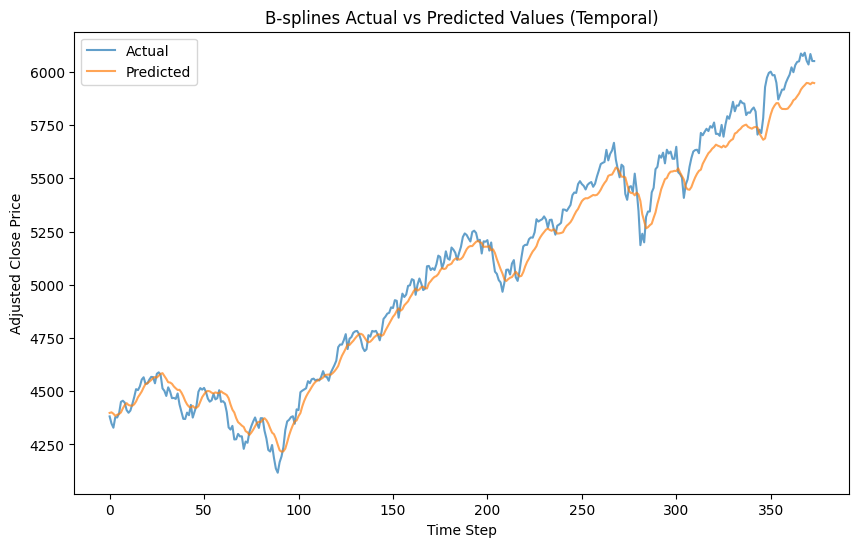

In [3]:
#tKAN B-splines
#In this piece of code, I have used a library called tKAN which uses the activation function called B-splines 
# I use MSE and the R^2 score value which measures variance in order to measure the performance of this model with the 
# activation function B-splines on the stock AdjClose feature 

X_train = X_train.reshape(-1, lookback, 1)  
X_val = X_val.reshape(-1, lookback, 1)
X_test = X_test.reshape(-1, lookback, 1)

model_tkan = Sequential([
    TKAN(200, sub_kan_configs=[{'spline_order': 4, 'grid_size': 12}, {'spline_order': 3, 'grid_size': 10}, {'spline_order': 5, 'grid_size': 8}], 
        return_sequences=False, use_bias=True),
    Dense(units=1, activation='linear')
])

model_tkan.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history_tkan = model_tkan.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

y_pred_tkan = model_tkan.predict(X_test)

mse_tkan = mean_squared_error(y_test, y_pred_tkan)
r2_tkan = r2_score(y_test, y_pred_tkan)
print(f"Test MSE: {mse_tkan:.4f}, R2: {r2_tkan:.4f}")


y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_tkan_inverse = scaler.inverse_transform(y_pred_tkan.reshape(-1, 1)).flatten()


plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label='Actual', alpha=0.7)
plt.plot(y_pred_tkan_inverse, label='Predicted', alpha=0.7)
plt.title('B-splines Actual vs Predicted Values (Temporal)')
plt.xlabel('Time Step')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.savefig('../outputs/temporal_bsplines.png', dpi=300, bbox_inches='tight')
plt.show()


Epoch 1/20


/Users/sunnyskar/Downloads/KAN_ap4617/.venv9/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:735: UserWarning: Gradients do not exist for variables ['sequential_1/tkan_1/tkan_cell_1/jacobi_weights'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0846 - mse: 0.0846 - val_loss: 0.0832 - val_mse: 0.0832
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.3712e-04 - mse: 7.3712e-04 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.7154e-04 - mse: 3.7154e-04 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.8579e-04 - mse: 3.8579e-04 - val_loss: 8.6254e-04 - val_mse: 8.6254e-04
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.5107e-04 - mse: 3.5107e-04 - val_loss: 9.6465e-04 - val_mse: 9.6465e-04
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.3493e-04 - mse: 5.3493e-04 - val_loss: 8.9666e-04 - val_mse: 8.9666e-04
Epoch 9/20


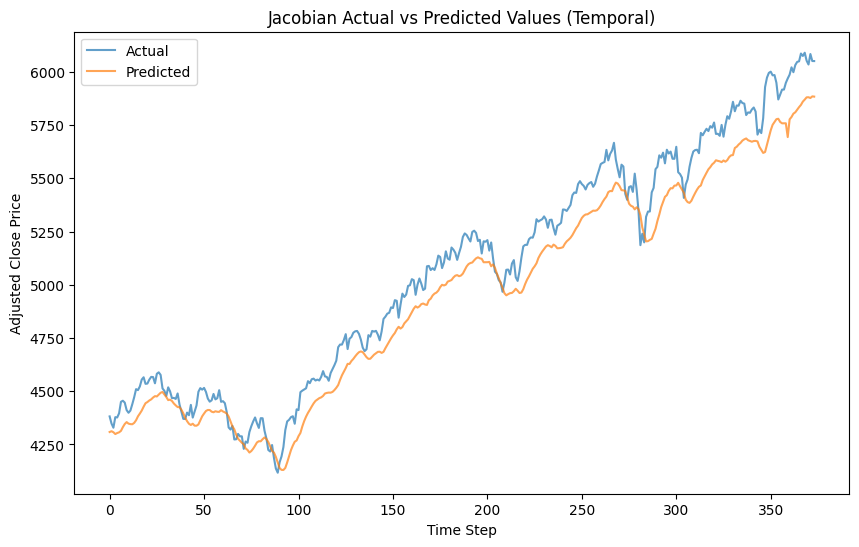

In [4]:
#tKAN Jacobi
#In this piece of code, I have used a library called tKAN which uses the activation function called Jacobi
# I use MSE and the R^2 score value which measures variance in order to measure the performance of this model with the 
# activation function Jacobi on the stock AdjClose feature. In this code, I've imported the tkan_Jacobi library which has the code 
# which has the recurrent KAN implemented and called with Jacobi to make it temporal in nature

from tkan_Jacobi import TKAN as TKAN2
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Define the TKAN model with Jacobi activation
model_tkan_jacobi = Sequential([
    TKAN2(
        units=200,  # Hidden units
        sub_kan_configs=[
            {'spline_order': 5, 'grid_size': 12}, 
            {'spline_order': 4, 'grid_size': 10}, 
            {'spline_order': 4, 'grid_size': 8},  
        ],
        active_jacobi=True,  # Enable Jacobi activation
        jacobi_params=[0.5, 0.5],  
        return_sequences=False,  
        use_bias=True  
    ),
    Dense(units=1, activation='linear')  # Final Dense layer for output
])

# Compile the model
model_tkan_jacobi.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizer
    loss='mean_squared_error',  # Loss function
    metrics=['mse']  # Metrics to track
)

# Train the model
history = model_tkan_jacobi.fit(
    X_train, y_train,  # Training data
    validation_data=(X_val, y_val),  
    batch_size=32, 
    epochs=20,  
    verbose=1  
)

# Evaluate the model on the test set
test_loss, test_mse = model_tkan_jacobi.evaluate(X_test, y_test)


y_pred = model_tkan_jacobi.predict(X_test)
mse_tkan = mean_squared_error(y_test, y_pred)
r2_tkan = r2_score(y_test, y_pred)
print(f"Test MSE: {mse_tkan:.4f}, R2: {r2_tkan:.4f}")

y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()


plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual', alpha=0.7)
plt.plot(y_pred_rescaled, label='Predicted', alpha=0.7)
plt.title('Jacobian Actual vs Predicted Values (Temporal)')
plt.xlabel('Time Step')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.savefig('../outputs/temporal_jacobian.png', dpi=300, bbox_inches='tight')
plt.show()





In [5]:
#tKAN Chebyshev
#In this piece of code, I have used a library called tKAN which uses the activation function called Chebyshev
# I use MSE and the R^2 score value which measures variance in order to measure the performance of this model with the 
# activation function Chebyshev on the stock AdjClose feature. In this code, I've imported the tkan_Chebyshev library which has the code 
# which has the recurrent KAN implemented and called with Chebyshev to make it temporal in nature


from tkan_Chebyshev import TKAN as TKAN3
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tkan import TKAN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score


ticker = '^GSPC'

sp500_data = yf.download(ticker, start='2015-01-01', end='2024-12-31')

csv_file = '../sp500_data.csv'
sp500_data.to_csv(csv_file)
print(f"Data saved to {csv_file}")

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file)
df = df.iloc[2:].reset_index(drop=True)
df = df.rename({'Price': 'Date'}, axis='columns')

# Extract the 'Adj Close' column as a numpy array
adj_close = df['Adj Close'].values

# Define a function to create sequences with a lookback window
def create_sequences(data, lookback=15):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])  
        y.append(data[i + lookback])   
    return np.array(X), np.array(y)

# Create sequences
lookback = 15
X, y = create_sequences(adj_close, lookback)


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)



scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

X_train = np.expand_dims(X_train, axis=1)  # Add time dimension
X_val = np.expand_dims(X_val, axis=1)      
X_test = np.expand_dims(X_test, axis=1)   


# Check the shapes of the datasets
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

[*********************100%***********************]  1 of 1 completed

Data saved to ../sp500_data.csv
Train set: (1743, 1, 15) (1743,)
Validation set: (373, 1, 15) (373,)
Test set: (374, 1, 15) (374,)


Epoch 1/20


/Users/sunnyskar/Downloads/KAN_ap4617/.venv9/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:735: UserWarning: Gradients do not exist for variables ['sequential_2/tkan_2/tkan_cell_2/cheby_weight'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0364 - mse: 0.0364 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2011e-04 - mse: 6.2011e-04 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4325e-04 - mse: 6.4325e-04 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3221e-04 - mse: 6.3221e-04 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9197e-04 - mse: 5.9197e-04 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6966e-04 - mse: 5.6966e-04 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2781e-04 - mse: 5.2781e-04 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━

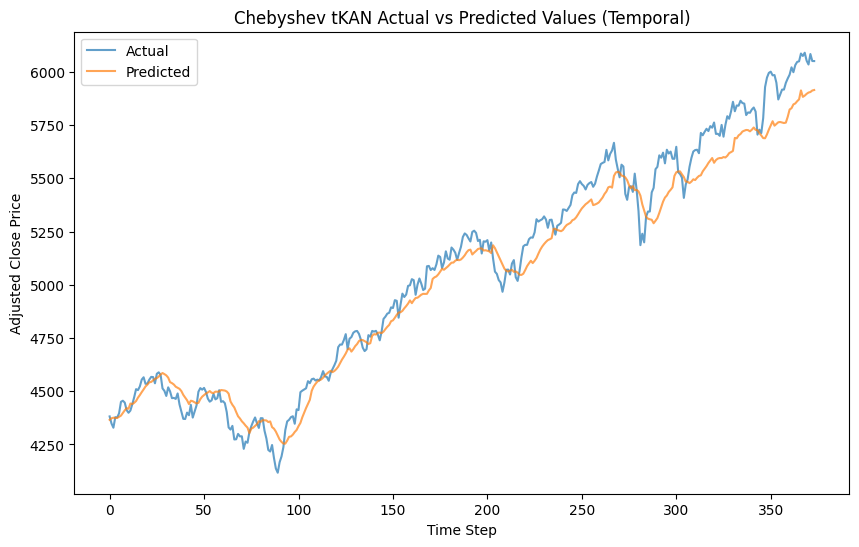

In [6]:
# Define the TKAN model with Chebyshev activation

model_tkan_chebyshev = Sequential([
    TKAN3(
        units=200,  
        sub_kan_configs=[
            {'spline_order': 4, 'grid_size': 12},  
            {'spline_order': 3, 'grid_size': 10},  
            {'spline_order': 5, 'grid_size': 8},   
        ],
        return_sequences=False,  # Return only the last output
        use_bias=True,  # Use bias in the layers, 
        active_chebyshev=True
    ),
    Dense(units=1, activation='linear')  # Final Dense layer for output
])

# Compile the model
model_tkan_chebyshev.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='mean_squared_error',  
    metrics=['mse']  
)

# Train the model
history = model_tkan_chebyshev.fit(
    X_train, y_train,  
    validation_data=(X_val, y_val),  
    batch_size=32,  
    epochs=20,  
    verbose=1  
)

# Evaluate the model on the test set
test_loss, test_mse = model_tkan_chebyshev.evaluate(X_test, y_test)

y_pred_cheby = model_tkan_chebyshev.predict(X_test)
mse_tkan_cheby = mean_squared_error(y_pred_cheby, y_test)
r2_tkan_cheby = r2_score(y_test, y_pred_cheby)
print(f"Test MSE: {mse_tkan_cheby:.4f}, R2: {r2_tkan_cheby:.4f}")

y_pred_rescaled_cheby = scaler.inverse_transform(y_pred_cheby.reshape(-1, 1)).flatten()
y_test_rescaled_cheby = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled_cheby, label='Actual', alpha=0.7)
plt.plot(y_pred_rescaled_cheby, label='Predicted', alpha=0.7)
plt.title('Chebyshev tKAN Actual vs Predicted Values (Temporal)')
plt.xlabel('Time Step')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.savefig('../outputs/temporal_chebyshev.png', dpi=300, bbox_inches='tight')
plt.show()